<h2 style="color:black;">Lab3 </h2>

<hr style="border:2px solid black;">

<h4 style="color:black;">Realised by:</h4>
<ul>
    <li><strong style="color:black;">Aicha Kharbach</strong></li>
</ul>

<h4 style="color:black;">Guided by:</h4> 
<ul>
    <li><strong style="color:black;">Pr . ELAACHAk LOTFI</strong></li>
</ul>
<p><strong>The main purpose behind this lab is to get familiar with NLP language models
using Sklearn library.</p>

# Part 2: Language Modeling / Classification

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report
from nltk.translate.bleu_score import sentence_bleu
import re
import nltk

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Load data with headers
train_data = pd.read_csv('twitter_training.csv', header=None, names=["Tweet ID", "Entity", "Sentiment", "Tweet content"])
valid_data = pd.read_csv('twitter_validation.csv', header=None, names=["Tweet ID", "Entity", "Sentiment", "Tweet content"])

In [5]:
train_data

,Tweet ID,Entity,Sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [6]:
valid_data

,Tweet ID,Entity,Sentiment,Tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [7]:
# Ensure all "Tweet content" values are strings and handle NaN values
train_data["Tweet content"] = train_data["Tweet content"].astype(str).fillna('')
valid_data["Tweet content"] = valid_data["Tweet content"].astype(str).fillna('')

# Data Preprocessing

In [8]:
# Text preprocessing
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return lemmatized_tokens

In [9]:
train_data["Tweet content"] = train_data["Tweet content"].apply(preprocess_text)
valid_data["Tweet content"] = valid_data["Tweet content"].apply(preprocess_text)

In [10]:
train_data

,Tweet ID,Entity,Sentiment,Tweet content
0,2401,Borderlands,Positive,"[im, getting, borderland, murder]"
1,2401,Borderlands,Positive,"[coming, border, kill]"
2,2401,Borderlands,Positive,"[im, getting, borderland, kill]"
3,2401,Borderlands,Positive,"[im, coming, borderland, murder]"
4,2401,Borderlands,Positive,"[im, getting, borderland, 2, murder]"
...,...,...,...,...
74677,9200,Nvidia,Positive,"[realized, window, partition, mac, like, 6, ye..."
74678,9200,Nvidia,Positive,"[realized, mac, window, partition, 6, year, be..."
74679,9200,Nvidia,Positive,"[realized, window, partition, mac, 6, year, be..."
74680,9200,Nvidia,Positive,"[realized, window, partition, mac, like, 6, ye..."


# Feature Encoding with Word Embeddings

In [11]:
# Train Word2Vec model on the training dataset
word2vec_model = Word2Vec(sentences=train_data["Tweet content"], vector_size=300, window=5, min_count=2, workers=4)

In [12]:
# Function to convert text to vector
def text_to_vec(text, model):
    vecs = [model.wv[word] for word in text if word in model.wv.key_to_index]
    if vecs:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(model.vector_size)

In [13]:
# Convert texts to vectors
train_data["Tweet content"] = train_data["Tweet content"].apply(lambda x: text_to_vec(x, word2vec_model))
valid_data["Tweet content"] = valid_data["Tweet content"].apply(lambda x: text_to_vec(x, word2vec_model))

In [14]:
train_data

,Tweet ID,Entity,Sentiment,Tweet content
0,2401,Borderlands,Positive,"[0.38494763, -0.31207985, 0.2917876, 0.3078884..."
1,2401,Borderlands,Positive,"[0.0057370663, -0.21527676, 0.28877544, 0.2751..."
2,2401,Borderlands,Positive,"[0.3397277, -0.39496392, 0.31143337, 0.3145786..."
3,2401,Borderlands,Positive,"[0.30974674, -0.35151985, 0.29039663, 0.373768..."
4,2401,Borderlands,Positive,"[0.37154058, -0.5930731, 0.36057585, 0.3114067..."
...,...,...,...,...
74677,9200,Nvidia,Positive,"[-0.075661756, -0.21181722, 0.26808974, 0.3924..."
74678,9200,Nvidia,Positive,"[-0.021189978, -0.18679976, 0.26499543, 0.3094..."
74679,9200,Nvidia,Positive,"[-0.021189982, -0.18679976, 0.26499543, 0.3094..."
74680,9200,Nvidia,Positive,"[-0.100836314, -0.14940593, 0.3286343, 0.47750..."


In [15]:
X_train = np.vstack(train_data["Tweet content"].values)
y_train = train_data["Sentiment"]
X_valid = np.vstack(valid_data["Tweet content"].values)
y_valid = valid_data["Sentiment"]

# Model Training with Various Algorithms

In [16]:
# Define evaluation function
def evaluate_model(model, X_valid, y_valid):
    y_pred = model.predict(X_valid)
    y_proba = model.predict_proba(X_valid) if hasattr(model, 'predict_proba') else None
    acc = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='weighted')
    loss = log_loss(y_valid, y_proba) if y_proba is not None else None
    bleu_scores = [sentence_bleu([str(y_true)], str(y_pred)) for y_true, y_pred in zip(y_valid, y_pred)]
    bleu = np.mean(bleu_scores)
    report = classification_report(y_valid, y_pred)
    return acc, f1, loss, bleu, report

In [26]:
# Train and evaluate SVM
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
svm_acc, svm_f1, svm_loss, svm_bleu, svm_report = evaluate_model(svm_model, X_valid, y_valid)
print(f"SVM Evaluation:\nAccuracy: {svm_acc}\nF1 Score: {svm_f1}\nLog Loss: {svm_loss}\nBLEU Score: {svm_bleu}\n{svm_report}")

SVM Evaluation:
{'Accuracy': 0.7750511247443763, 'F1 Score': 0.868421052631579, 'Log Loss': 0.4352877700555024, 'BLEU Score': 1.4120129325148972e-231}


C:\Users\hp\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\hp\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\hp\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [27]:
# Train and evaluate Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_acc, lr_f1, lr_loss, lr_bleu, lr_report = evaluate_model(lr_model, X_valid, y_valid)
print(f"Logistic Regression Evaluation:\nAccuracy: {lr_acc}\nF1 Score: {lr_f1}\nLog Loss: {lr_loss}\nBLEU Score: {lr_bleu}\n{lr_report}")

Logistic Regression Evaluation:
{'Accuracy': 0.7668711656441718, 'F1 Score': 0.8609756097560975, 'Log Loss': 0.4954601749938298, 'BLEU Score': 1.39711042135379e-231}


C:\Users\hp\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\hp\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\hp\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [28]:
# Train and evaluate AdaBoost
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
ada_acc, ada_f1, ada_loss, ada_bleu, ada_report = evaluate_model(ada_model, X_valid, y_valid)
print(f"AdaBoost Evaluation:\nAccuracy: {ada_acc}\nF1 Score: {ada_f1}\nLog Loss: {ada_loss}\nBLEU Score: {ada_bleu}\n{ada_report}")

AdaBoost Evaluation:
{'Accuracy': 0.7198364008179959, 'F1 Score': 0.8218465539661899, 'Log Loss': 0.6815424784617936, 'BLEU Score': 1.3114209821774243e-231}


C:\Users\hp\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\hp\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\hp\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

# Model Evaluation and Selection

In [30]:
# Summarize all evaluations
evaluations = pd.DataFrame({
    'Model': ['SVM','Logistic Regression', 'AdaBoost'],
    'Accuracy': [svm_acc, nb_acc, lr_acc, ada_acc],
    'F1 Score': [svm_f1, nb_f1, lr_f1, ada_f1],
    'Log Loss': [svm_loss, nb_loss, lr_loss, ada_loss],
    'BLEU Score': [svm_bleu, nb_bleu, lr_bleu, ada_bleu]
})

print("Evaluations Summary:")
print(evaluations)

# Choose the best model
best_model = evaluations.loc[evaluations['Accuracy'].idxmax()]
print("\nBest Model:")
print(best_model)

Evaluations Summary:
                 Model  Accuracy  F1 Score  Log Loss     BLEU Score
0                  SVM  0.775051  0.868421  0.435288  1.412013e-231
1  Logistic Regression  0.766871  0.860976  0.495460  1.397110e-231
2             AdaBoost  0.719836  0.821847  0.681542  1.311421e-231

Best Model:
Model              SVM
Accuracy      0.775051
F1 Score      0.868421
Log Loss      0.435288
BLEU Score         0.0
Name: 0, dtype: object


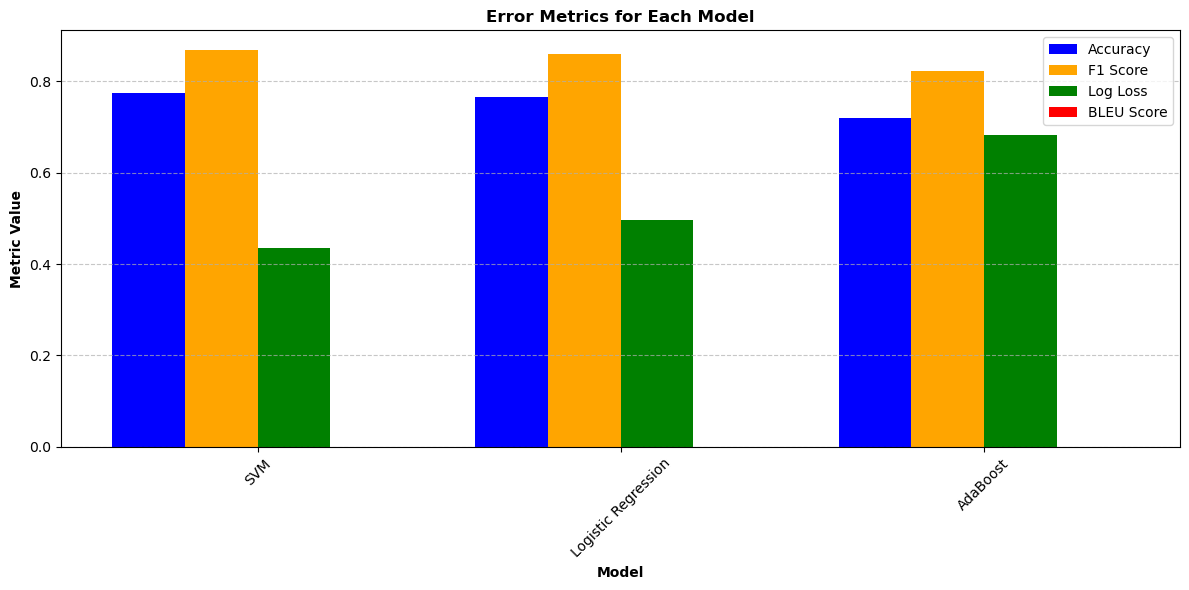

In [31]:

# Plotting the error metrics for each model
models = ['SVM',  'Logistic Regression', 'AdaBoost']
accuracy_values = evaluations['Accuracy']
f1_values = evaluations['F1 Score']
log_loss_values = evaluations['Log Loss']
bleu_values = evaluations['BLEU Score']

bar_width = 0.2

r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

plt.figure(figsize=(12, 6))
plt.bar(r1, accuracy_values, color='blue', width=bar_width, label='Accuracy')
plt.bar(r2, f1_values, color='orange', width=bar_width, label='F1 Score')
plt.bar(r3, log_loss_values, color='green', width=bar_width, label='Log Loss')
plt.bar(r4, bleu_values, color='red', width=bar_width, label='BLEU Score')

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + 1.5 * bar_width for r in range(len(models))], models, rotation=45)

plt.ylabel('Metric Value', fontweight='bold')
plt.title('Error Metrics for Each Model', fontweight='bold')
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()